# Comparing processing data to original

It appears that some processed models are missing some data see [here](/home/links/ct715/eddy_feedback/chapter1/resolution/original_res_components.ipynb). 

Here I will start by comparing the model I was using (HadGEM3-GC31-MM), and rerun the processing to see where the issue is.

I'll then extend this to other models that have an issue.

In [1]:
import xarray as xr
import functions.eddy_feedback as ef
import functions.data_wrangling as data

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

### Processed data

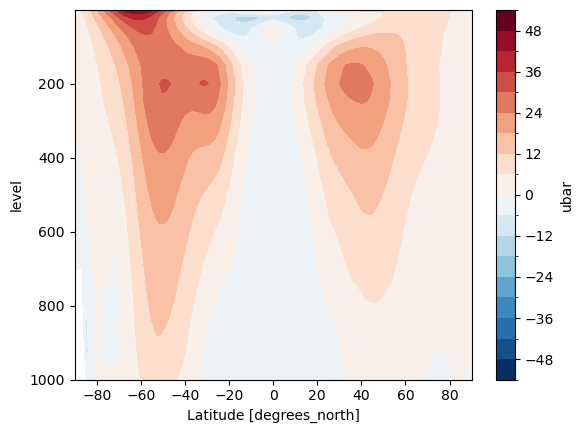

In [2]:
ds = xr.open_mfdataset('/home/links/ct715/data_storage/PAMIP/processed_monthly/missing_data_files/HadGEM3-GC31-MM*.nc')
ds.ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False)

### Original data

In [3]:
og_ua = xr.open_mfdataset(
    '/home/links/ct715/data_storage/PAMIP/monthly/1.1_pdSST-pdSIC/ua/HadGEM3-GC31-MM/*.nc',
    combine='nested',
    concat_dim='ens_ax',
    parallel=True,
    chunks={'time': 31}
)
og_ua

<xarray.Dataset>
Dimensions:    (time: 14, ens_ax: 300, bnds: 2, plev: 19, lat: 325, lon: 432)
Coordinates:
  * time       (time) object 2000-04-16 00:00:00 ... 2001-05-16 00:00:00
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * lat        (lat) float64 -90.0 -89.44 -88.89 -88.33 ... 88.89 89.44 90.0
  * lon        (lon) float64 0.0 0.8333 1.667 2.5 ... 356.7 357.5 358.3 359.2
Dimensions without coordinates: ens_ax, bnds
Data variables:
    time_bnds  (ens_ax, time, bnds) object dask.array<chunksize=(1, 14, 2), meta=np.ndarray>
    lat_bnds   (ens_ax, time, lat, bnds) float64 dask.array<chunksize=(1, 14, 325, 2), meta=np.ndarray>
    lon_bnds   (ens_ax, time, lon, bnds) float64 dask.array<chunksize=(1, 14, 432, 2), meta=np.ndarray>
    ua         (ens_ax, time, plev, lat, lon) float32 dask.array<chunksize=(1, 14, 19, 325, 432), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            PAMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54090.0
    creation_date:          2020-09-17T22:45:26Z
    ...                     ...
    tracking_id:            hdl:21.14100/94ec2da6-a427-45ec-bad7-33c875a9aa30
    variable_id:            ua
    variable_name:          ua
    variant_label:          r100i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [4]:
og_epfy = xr.open_mfdataset(
    '/home/links/ct715/data_storage/PAMIP/monthly/1.1_pdSST-pdSIC/epfy/HadGEM3-GC31-MM/*.nc',
    combine='nested',
    concat_dim='ens_ax',
    parallel=True,
    chunks={'time': 31}
)
og_epfy.plev.values

array([1.00000000e+05, 9.25000000e+04, 8.50000000e+04, 7.00000000e+04,
       6.00000000e+04, 5.00000000e+04, 4.00000000e+04, 3.00000000e+04,
       2.50000000e+04, 2.00000000e+04, 1.70000000e+04, 1.50000000e+04,
       1.30000000e+04, 1.15000000e+04, 1.00000000e+04, 9.00000000e+03,
       8.00000000e+03, 7.00000000e+03, 5.00000000e+03, 3.00000000e+03,
       2.00000000e+03, 1.50000000e+03, 1.00000000e+03, 7.00000000e+02,
       5.00000000e+02, 3.00000000e+02, 2.00000000e+02, 1.50000000e+02,
       1.00000000e+02, 6.99999988e+01, 5.00000000e+01, 4.00000006e+01,
       3.00000012e+01, 2.00000003e+01, 1.50000006e+01, 1.00000001e+01,
       7.00000003e+00, 5.00000007e+00, 2.99999993e+00])

In [5]:
og_ua = data.data_checker1000(og_ua)
og_epfy = data.data_checker1000(og_epfy)

In [6]:
if not og_ua.level.equals(og_epfy.level):
    if len(og_ua.level) > len(og_epfy.level):
        ua = og_ua.interp(level=og_epfy.level)
        epfy = og_epfy
    else:
        ua = og_ua
        epfy = og_epfy.interp(level=og_ua.level)
else:
    ua, epfy = og_ua, og_epfy  # Use original DataArrays if levels match

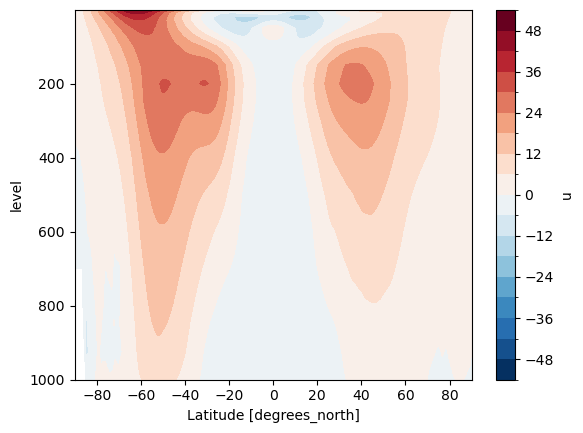

In [7]:
og_ua.u.mean(('time', 'lon', 'ens_ax')).plot.contourf(levels=20, yincrease=False)

### Reprocess the data

In [8]:
ds = xr.Dataset({
    'ubar': og_ua.u.mean('lon'),
    'epfy': og_epfy.epfy
})
ds = ds.sel(time=slice('2000-06', '2001-05'))
ds

<xarray.Dataset>
Dimensions:  (time: 12, level: 39, lat: 325, ens_ax: 300)
Coordinates:
  * time     (time) object 2000-06-16 00:00:00 ... 2001-05-16 00:00:00
  * level    (level) float64 0.03 0.05 0.07 0.1 0.15 ... 700.0 850.0 925.0 1e+03
  * lat      (lat) float64 -90.0 -89.44 -88.89 -88.33 ... 88.33 88.89 89.44 90.0
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, time, level, lat) float32 dask.array<chunksize=(1, 12, 39, 325), meta=np.ndarray>
    epfy     (ens_ax, time, level, lat) float32 dask.array<chunksize=(1, 12, 39, 325), meta=np.ndarray>

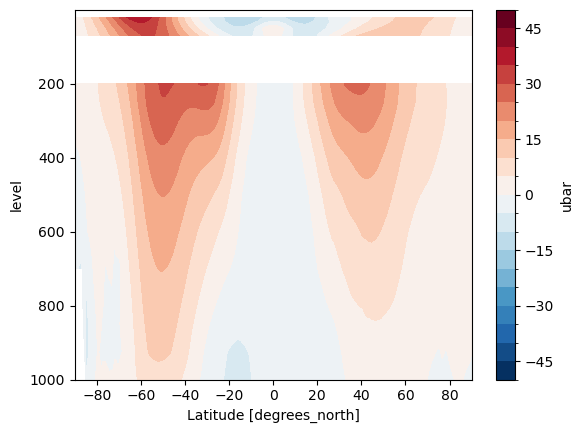

In [9]:
ds.ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False)

In [10]:
new_ds = ef.calculate_divFphi(ds)
new_ds

<xarray.Dataset>
Dimensions:  (time: 12, level: 39, lat: 325, ens_ax: 300)
Coordinates:
  * time     (time) object 2000-06-16 00:00:00 ... 2001-05-16 00:00:00
  * level    (level) float64 0.03 0.05 0.07 0.1 0.15 ... 700.0 850.0 925.0 1e+03
  * lat      (lat) float64 -90.0 -89.44 -88.89 -88.33 ... 88.33 88.89 89.44 90.0
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, time, level, lat) float32 dask.array<chunksize=(1, 12, 39, 325), meta=np.ndarray>
    epfy     (ens_ax, time, level, lat) float32 dask.array<chunksize=(1, 12, 39, 325), meta=np.ndarray>
    divFy    (ens_ax, time, level, lat) float64 -5.424e+22 ... -1.01e+22

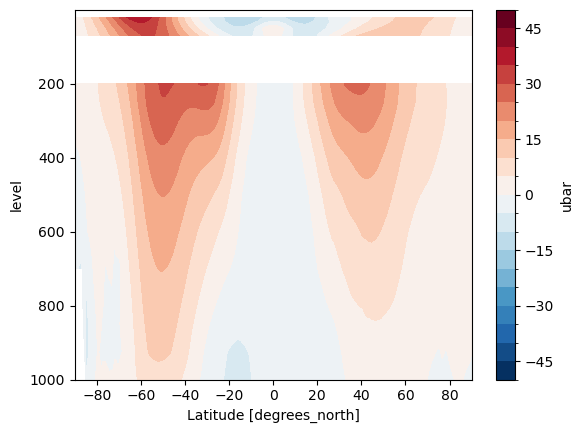

In [11]:
new_ds.ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False)